# Import libraries

In [0]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

#import df_pipeline as dfp  # all the custom pipeline parts
#import explore_data as exp  # all function to quickly explore the data

import warnings

pd.set_option('max_columns', 200)

In [8]:
from google.colab import files
uploaded_train = files.upload()

Saving train.csv to train (2).csv


In [9]:
from google.colab import files
uploaded_test = files.upload()

Saving test.csv to test (2).csv


In [10]:
train = pd.read_csv(io.BytesIO(uploaded_train['train.csv']))
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
test =  pd.read_csv(io.BytesIO(uploaded_test['test.csv']))
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


# Plotting

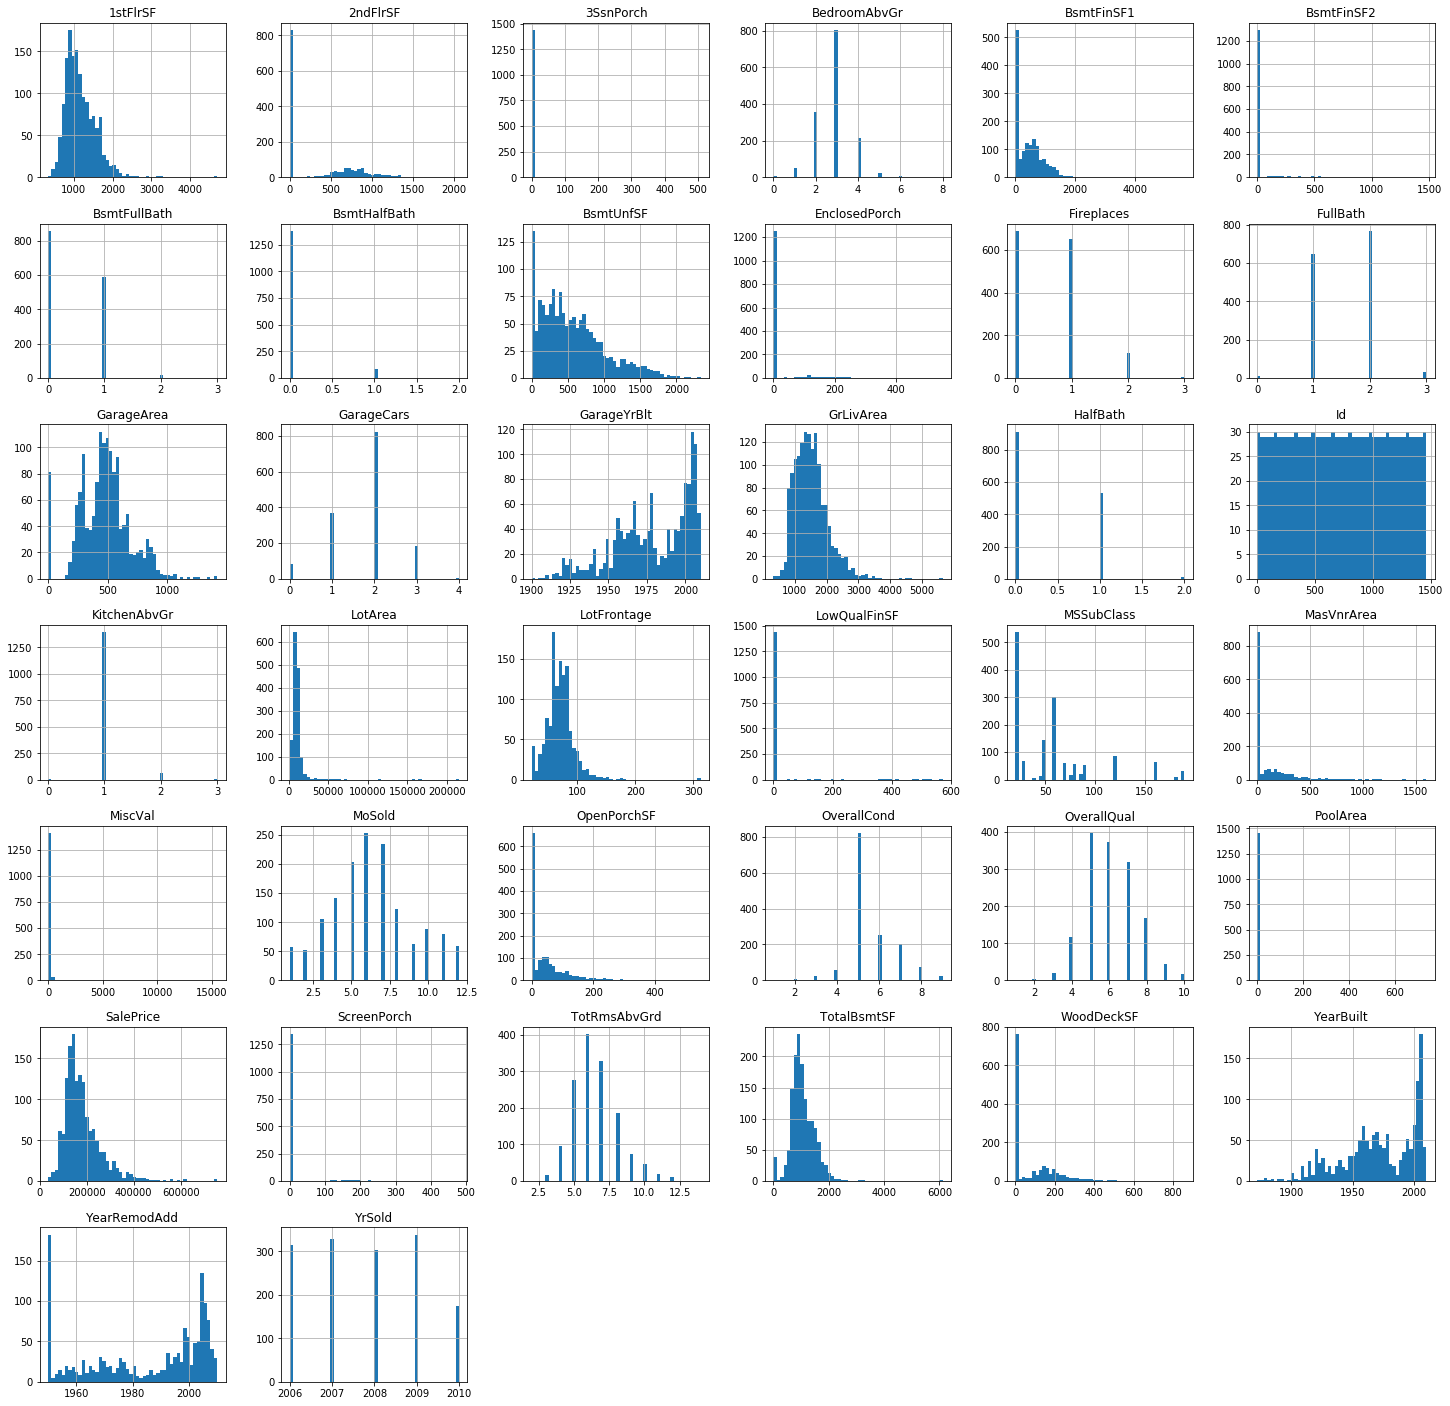

In [14]:
train.hist(bins=50, figsize=(25,25))
plt.show()



> Distribution SalePrice



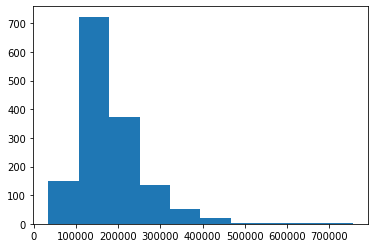

In [15]:
plt.hist(train['SalePrice'])
plt.show()

**The above histogram shows Skewness in target variable "Sale price". Let's confirm the same from normality test**

> Shapiro-Wilk test for normality. Normal Q-Q (quantile-quantile) plots.

*   Normally distributed should fall on straight line through first/third (middle) quartiles



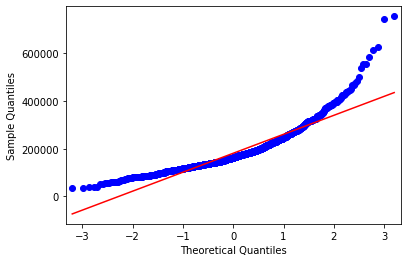

In [16]:
from statsmodels.graphics.gofplots import qqplot

qqplot(train['SalePrice'], line='s')
plt.show()

**Spread of salesprice over 4 quartile**

In [17]:
from scipy.stats import shapiro
# normality test
stat, p = shapiro(train['SalePrice'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.870, p=0.000
Sample does not look Gaussian (reject H0)


**Shapiro normality test**

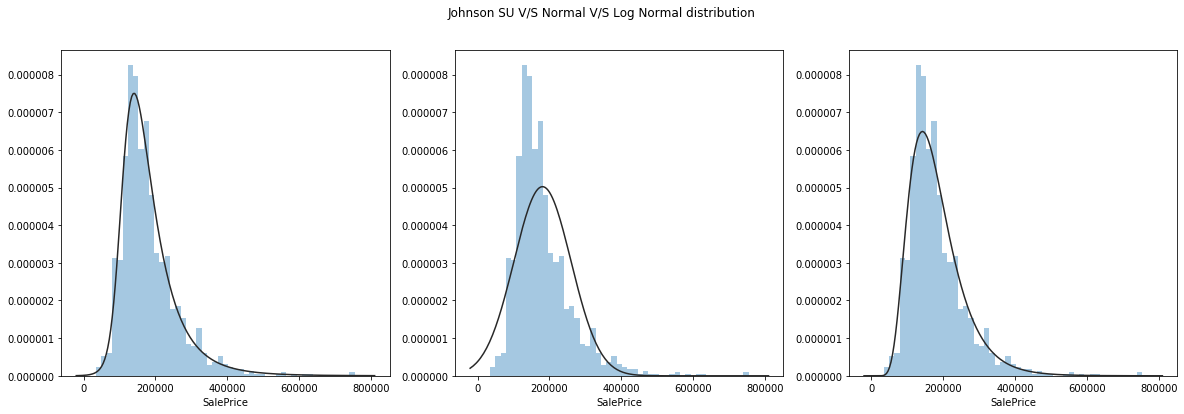

In [18]:
import scipy.stats as st
y = train['SalePrice']
fig, ax =plt.subplots(1,3,figsize=(20,6))
plt.suptitle('Johnson SU V/S Normal V/S Log Normal distribution')
sns.distplot(y, kde=False, fit=st.johnsonsu,ax=ax[0])
sns.distplot(y, kde=False, fit=st.norm,ax=ax[1])
sns.distplot(y, kde=False, fit=st.lognorm,ax=ax[2])
fig.show()

**Correlation map of salesprice with numerical column**

In [19]:
numerical = [f for f in train.columns if train.dtypes[f] != 'object']
numerical.remove('SalePrice')
# we don't required (Id not a feature)
numerical.remove('Id')
categorical = [f for f in train.columns if train.dtypes[f] == 'object']
print("numerical=",numerical)
print("categorical=",categorical)

numerical= ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
categorical= ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 

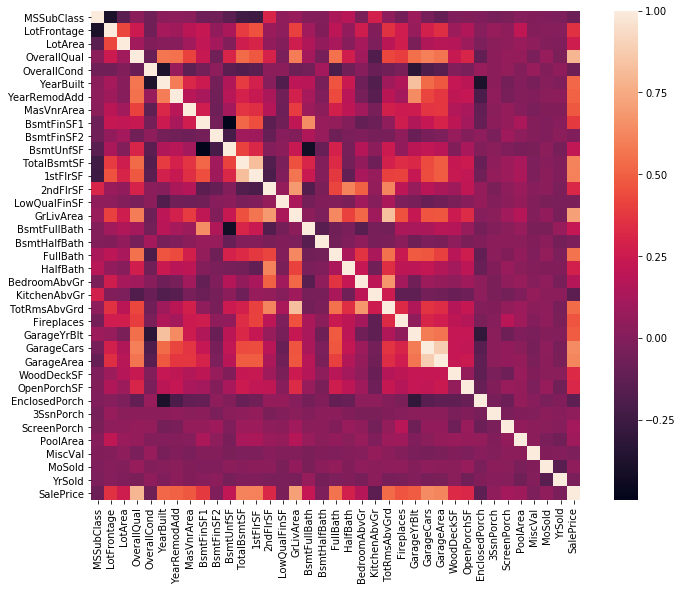

In [20]:
num = numerical + ['SalePrice']
corrmat = train[num].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

# Split variables in numerical (discrete, continuous) and categorical (ordinal, nominal)

> Continiuous - infinite options

> Discrete - finite options

> Ordinal - data has a hierarchy

> Nominal - data has no herarchy



![alt text](http://survivestatistics.com/wp-content/uploads/2016/07/variables3.jpg)

[Image Source](http://survivestatistics.com/variables/)

In [21]:
num = np.array(train.dtypes!="object")
print("numeric type",sum(num) )
cat = np.array(train.dtypes=="object")
print("object type", sum(cat))

numeric type 38
object type 43


In [0]:
num_discrete = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold']

num_continuous = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                  '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                  '3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

cat_ordinal = ['LotShape','Utilities','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir',
               'Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
               'PavedDrive','PoolQC','Fence']

cat_nominal = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
               'Exterior2nd','MasVnrType','Foundation','Heating','GarageType','MiscFeature',
               'SaleType','SaleCondition']

# Remove outliers with Low Price


> We can define as outliers all the values with z score > 3 or z score < 3. The number of outliers of the features with, at least, weak correlation with Sale Price and a low % of zeros will be presented. Then, the scatterplots of the variables will be plotted to detect the outliers with Low Price.


---







> Defining a z score function. It will return a normalized value (z-score) based on **the mean and standard deviation**. *A z-score, or standard score*, is used for standardizing scores on the same scale by dividing a score’s deviation by the standard deviation in a data set. The result is a standard score. *It measures the number of standard deviations that a given data point is from the mean.*



In [0]:
def z_score(df): 
    return (df-df.mean())/df.std(ddof=0)

In [24]:
# Let's take a look at the number of outliers of the variables with correlation > 0.3 and % of zeros < 30%

idx = []
outliers = []
corrs = []
zeros = []

for i in num_continuous:
    if str(train[i].dtype) != 'object':
        idx.append(i)
        outliers.append(list(abs(z_score(train[i])) > 3).count(True))
        corrs.append(train.SalePrice.corr(train[i]))
        zeros.append(len(train[i][train[i] == 0])/len(train[i]))
        
outs = pd.DataFrame({'# Outliers': outliers, 
                     'Feature': idx, 
                     'Corr': corrs, 
                     '% Zeros': zeros}).sort_values(ascending = False, 
                                                 by = '# Outliers')

outs = outs[outs["# Outliers"] > 0]
outs = outs[abs(outs["Corr"]) > 0.3].reset_index(drop=True)
outs = outs[outs["% Zeros"] < 0.3].reset_index(drop=True)
outs

,# Outliers,Feature,Corr,% Zeros
0,22,SalePrice,1.000000,0.000000
1,16,GrLivArea,0.708624,0.000000
2,12,1stFlrSF,0.605852,0.000000
3,12,LotFrontage,0.351799,0.000000
4,10,TotalBsmtSF,0.613581,0.025342
5,7,GarageArea,0.623431,0.055479


In [0]:
# defining a function to plot the correlation of the variables shown above with SalePrice, so we can delete Low Price's outliers
from matplotlib.gridspec import GridSpec
def plot_outliers():
    
    fig = plt.figure(figsize=(15,15), constrained_layout=True)

    gs = GridSpec(3,2,figure=fig)

    rows = [0,0,1,1,2,2]
    columns = [0,1,0,1,0,1]

    colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

    counter = 0

    for i in outs.Feature:
        sns.scatterplot(y=train.SalePrice, x=train[i], 
                      ax=fig.add_subplot(gs[rows[counter],columns[counter]]),
                      color=colors[counter])
        counter = counter + 1

    fig.show()

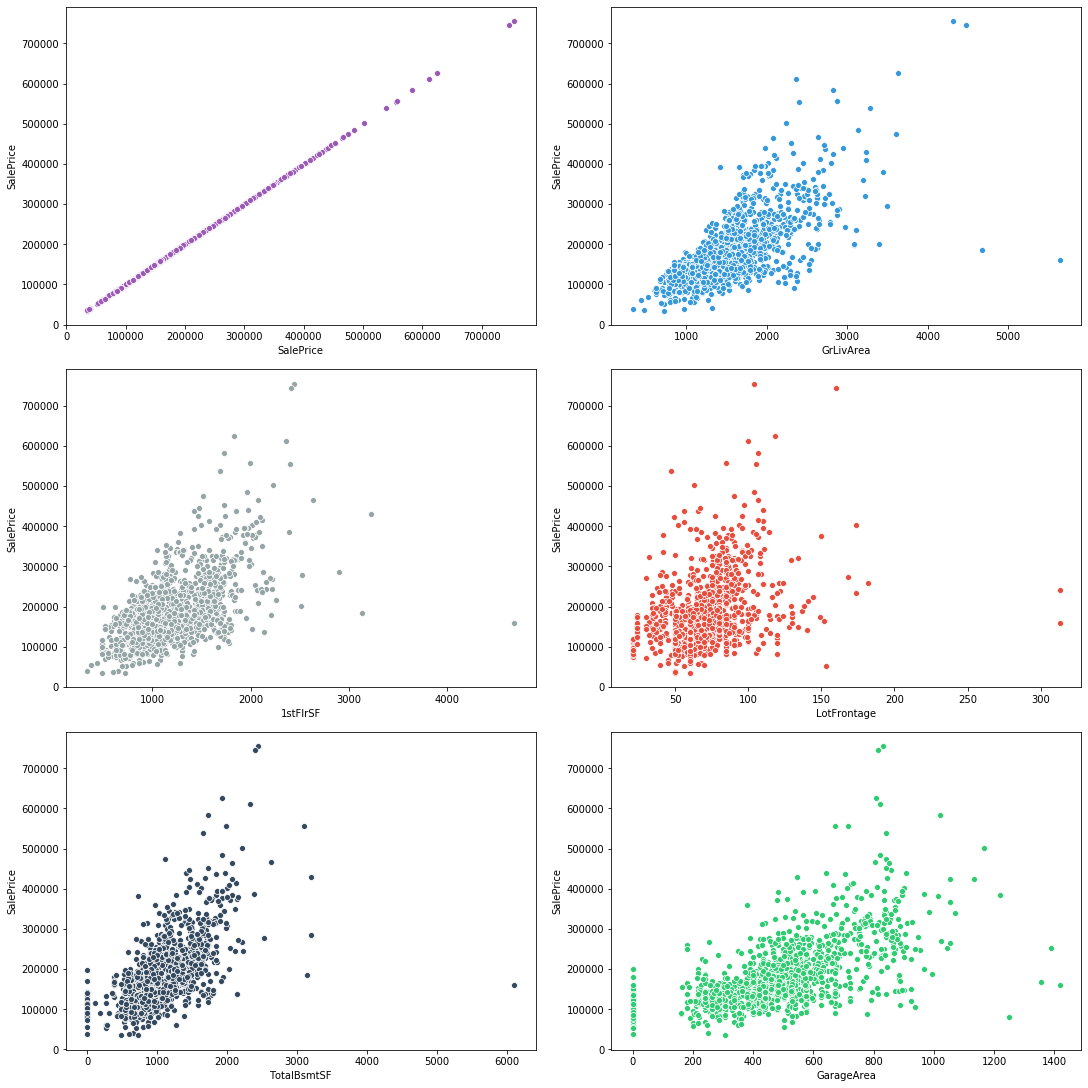

In [26]:
plot_outliers()



> As we can see there are two outliers with low price for GrLivArea, let's remove them.



In [27]:
train.shape

(1460, 81)

In [0]:
# removing GrLivArea outliers with Low Price
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

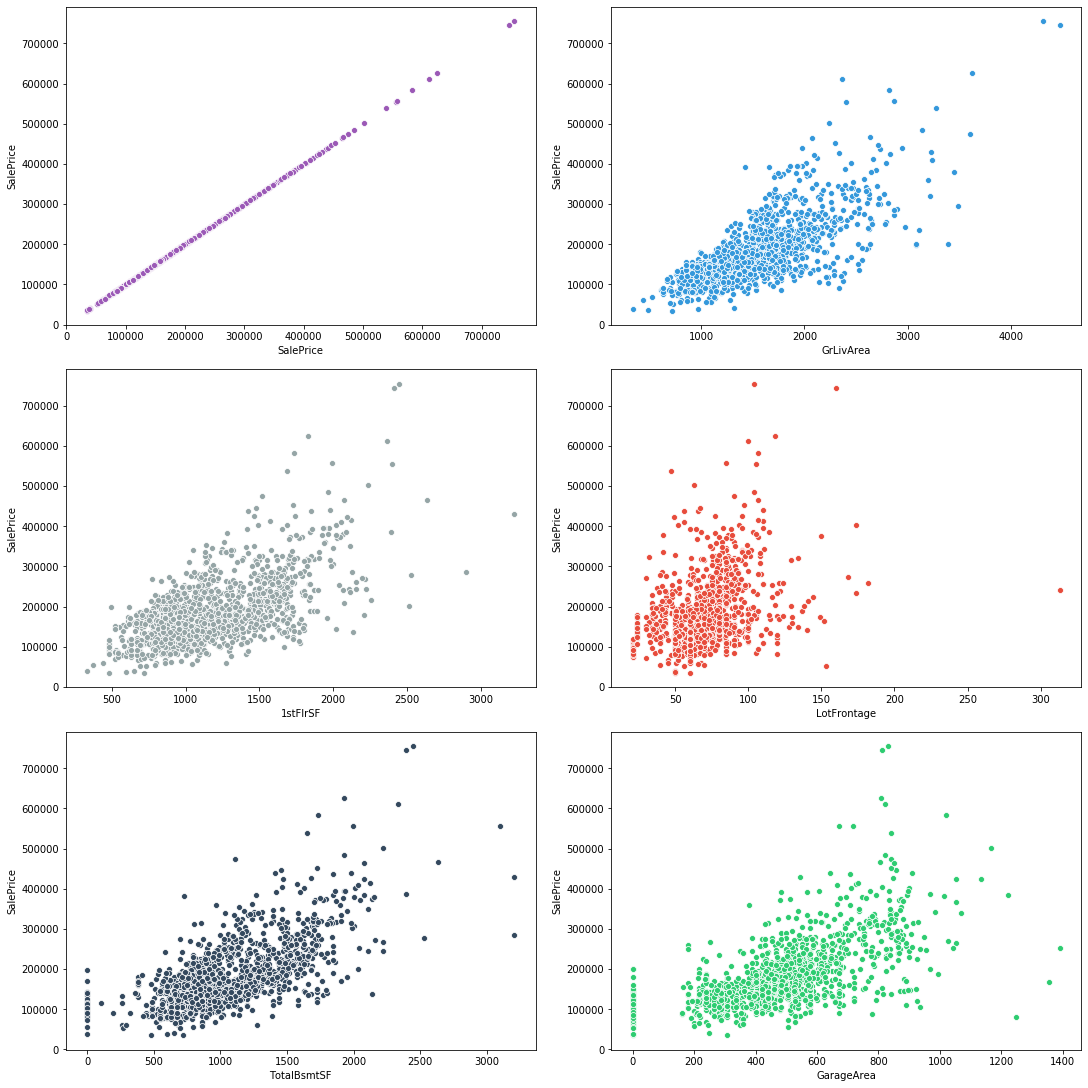

In [29]:
# plotting again
plot_outliers()

In [30]:
train.shape

(1458, 81)


> Ok, now it's enough. We can't delete a lot of outliers, because it can affect the results.





> Let's concatenate train and test sets into one, so we can analyze everything and fill NaN's based on all dataset.




In [0]:
dataset = pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
dataset = dataset.fillna(np.nan)

# Replace NaN's

> First, let's map all the missing data and then fill them based on median (if continuous) or mode (otherwise) or NA (if written in description).



---



In [32]:
# defining a function to map the # and % of NaN's for the features
def show_null(df):
    null_columns = (df.isnull().sum(axis = 0)/len(df)).sort_values(ascending=False).index
    null_data = pd.concat([df.isnull().sum(axis = 0),
                           (df.isnull().sum(axis = 0)/len(df)).sort_values(ascending=False),
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes]
                          , axis=1)
    null_data = null_data.rename(columns={0: '#', 
                                          1: '% null', 
                                          2: 'type'}).sort_values(ascending=False, by = '% null')
    null_data = null_data[null_data["#"]!=0]
    return null_data

show_null(dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,#,% null,type
PoolQC,2908,0.996915,object
MiscFeature,2812,0.964004,object
Alley,2719,0.932122,object
Fence,2346,0.804251,object
SalePrice,1459,0.500171,float64
FireplaceQu,1420,0.486802,object
LotFrontage,486,0.166610,float64
GarageQual,159,0.054508,object
GarageFinish,159,0.054508,object
GarageCond,159,0.054508,object


In [33]:
# Ordinals - Replacing NaN's

dataset.PoolQC[dataset.PoolQC.isnull() == True] = 'NA'
dataset.Fence[dataset.Fence.isnull() == True] = 'NA'
dataset.FireplaceQu[dataset.FireplaceQu.isnull() == True] = 'NA'
dataset.GarageCond[dataset.GarageCond.isnull() == True] = 'NA'
dataset.GarageQual[dataset.GarageQual.isnull() == True] = 'NA'
dataset.GarageFinish[dataset.GarageFinish.isnull() == True] = 'NA'
dataset.BsmtExposure[dataset.BsmtExposure.isnull() == True] = 'NA'
dataset.BsmtCond[dataset.BsmtCond.isnull() == True] = 'NA'
dataset.BsmtQual[dataset.BsmtQual.isnull() == True] = 'NA'
dataset.BsmtFinType2[dataset.BsmtFinType2.isnull() == True] = 'NA'
dataset.BsmtFinType1[dataset.BsmtFinType1.isnull() == True] = 'NA'
dataset.Electrical[dataset.Electrical.isnull() == True] = stats.mode(dataset.Electrical)[0][0]
dataset.Functional[dataset.Functional.isnull() == True] = stats.mode(dataset.Functional)[0][0]
dataset.KitchenQual[dataset.KitchenQual.isnull() == True] = stats.mode(dataset.KitchenQual)[0][0]
dataset.Utilities[dataset.Utilities.isnull() == True] = stats.mode(dataset.Utilities)[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [34]:
# Nominals - Replacing NaN's

dataset.MiscFeature[dataset.MiscFeature.isnull() == True] = 'NA'
dataset.Alley[dataset.Alley.isnull() == True] = 'NA'
dataset.GarageType[dataset.GarageType.isnull() == True] = 'NA'
dataset.MasVnrType[dataset.MasVnrType.isnull() == True] = 'NA'
dataset.MSZoning[dataset.MSZoning.isnull() == True] = stats.mode(dataset.MSZoning)[0][0]
dataset.SaleType[dataset.SaleType.isnull() == True] = stats.mode(dataset.SaleType)[0][0]
dataset.Exterior1st[dataset.Exterior1st.isnull() == True] = stats.mode(dataset.Exterior1st)[0][0]
dataset.Exterior2nd[dataset.Exterior2nd.isnull() == True] = stats.mode(dataset.Exterior2nd)[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [35]:
# Some Numericals - Replacing NaN's

dataset.BsmtFullBath[dataset.BsmtFullBath.isnull() == True] = stats.mode(dataset.BsmtFullBath)[0][0]
dataset.BsmtHalfBath[dataset.BsmtHalfBath.isnull() == True] = stats.mode(dataset.BsmtHalfBath)[0][0]
dataset.GarageCars[dataset.GarageCars.isnull() == True] = stats.mode(dataset.GarageCars)[0][0]
dataset.GarageArea[dataset.GarageArea.isnull() == True] = np.median(dataset.
                                                                    GarageArea[dataset.GarageArea.isnull() == False])
dataset.TotalBsmtSF[dataset.TotalBsmtSF.isnull() == True] = np.median(dataset.
                                                                      TotalBsmtSF[dataset.TotalBsmtSF.isnull() == False])
dataset.BsmtFinSF1[dataset.BsmtFinSF1.isnull() == True] = np.median(dataset.
                                                                    BsmtFinSF1[dataset.BsmtFinSF1.isnull() == False])
dataset.BsmtFinSF2[dataset.BsmtFinSF2.isnull() == True] = np.median(dataset.
                                                                    BsmtFinSF2[dataset.BsmtFinSF2.isnull() == False])
dataset.BsmtUnfSF[dataset.BsmtUnfSF.isnull() == True] = np.median(dataset.
                                                                  BsmtUnfSF[dataset.BsmtUnfSF.isnull() == False])
dataset.LotFrontage[dataset.LotFrontage.isnull() == True] = np.median(dataset.
                                                                    LotFrontage[dataset.LotFrontage.isnull() == False])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys



> Special cases:



In [0]:
# MasVnrArea

dataset[dataset.MasVnrArea.isnull() == True].MasVnrType



> So, we can see that the problem is not lack of information for MasVnrArea, but the NaN values happen just because there is no Masonry veener. Therefore we can define them as 0.



In [36]:
dataset.MasVnrArea[dataset.MasVnrArea.isnull() == True] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
# GarageYrBlt

dataset[["GarageType",
          "GarageFinish",
          "GarageQual",
          "GarageCond",
         "GarageYrBlt"]][dataset.GarageYrBlt.isnull() == True].dropna()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt




>So, we can see that the problem is not lack of information, but the NaN values happen just because there is no garage. Therefore, we can define them as NA.



In [38]:
dataset.GarageYrBlt[dataset.GarageYrBlt.isnull() == True] = 'NA'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
# Let's see again the # and % of NaN's 
show_null(dataset)

# SalePrice is ok, because NaN values are from test set.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,#,% null,type
SalePrice,1459,0.500171,float64


# [EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis) and data cleaning

> Here we will analyze each feature for Discrete, Continuous, Ordinal and Nominal variables.


---




In [0]:
# To remember
num_discrete = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold']


> We will analyze each discrete variable individually and make decisions based on correlation with SalePrice, lack of information in each category and so on.



In [0]:
# defining a function to plot boxplot and stripplot for non continuous variables
def make_discrete_plot(feature, rotation1, rotation2):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=dataset.SalePrice, x=dataset[feature], ax=fig.add_subplot(gs[0,0]))
    plt.xticks(rotation = rotation1)
    sns.stripplot(y=dataset.SalePrice, x=dataset[feature], ax=fig.add_subplot(gs[0,1]))
    plt.xticks(rotation = rotation2)
    fig.show()

Number of bathrooms.

---



In [0]:
# Those variables tell almost the same information, so let's add them.
dataset["Baths"] = dataset.BsmtFullBath + 0.5*dataset.BsmtHalfBath + dataset.FullBath + 0.5*dataset.HalfBath

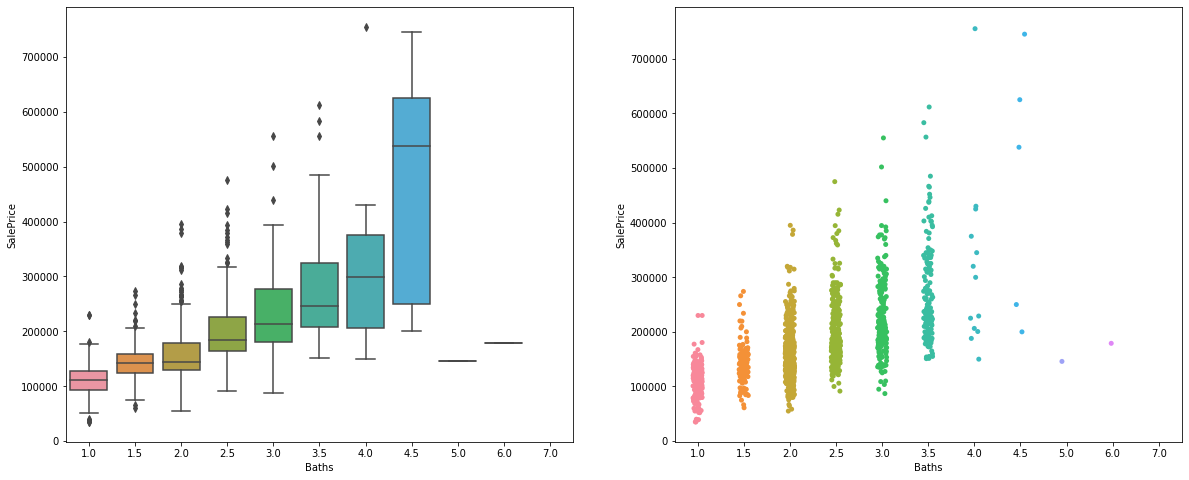

In [44]:
make_discrete_plot("Baths",0,0)

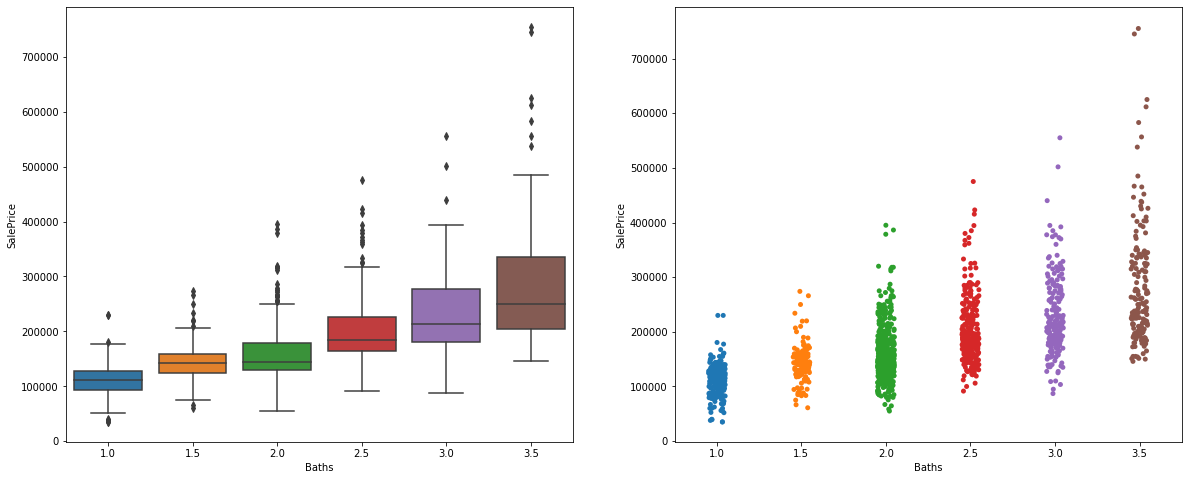

In [45]:
# there few values greater than 4, so let's put them together with 3.5
dataset.Baths = dataset.Baths.apply(lambda x: 3.5 if x > 3.5 else x)
make_discrete_plot("Baths",0,0)

BedroomAbvGr

---



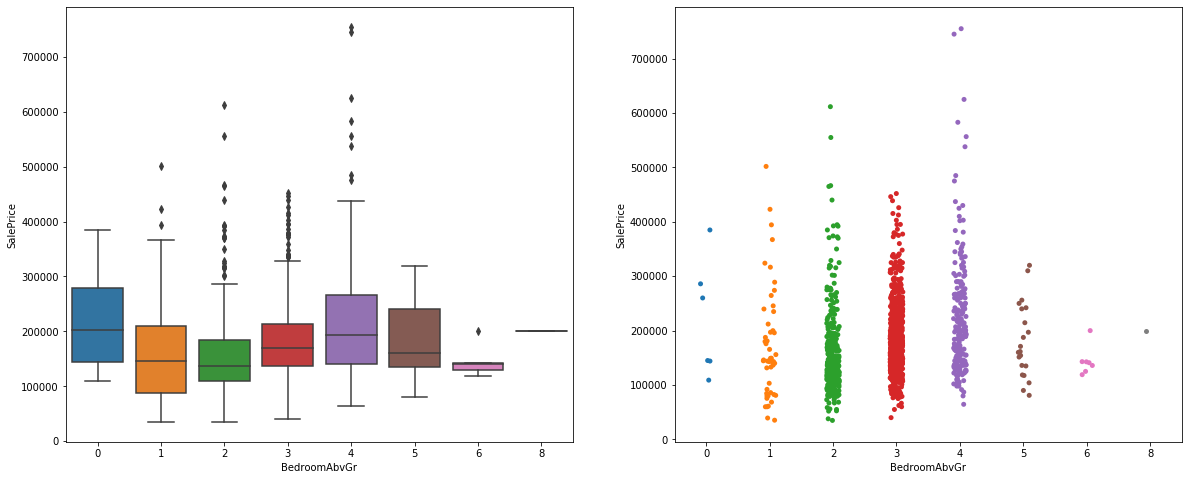

In [46]:
make_discrete_plot("BedroomAbvGr",0,0)

In [0]:
# there few values greater than 5, so let's put them together with 5
dataset.BedroomAbvGr = dataset.BedroomAbvGr.apply(lambda x: 5 if x > 5 else x)

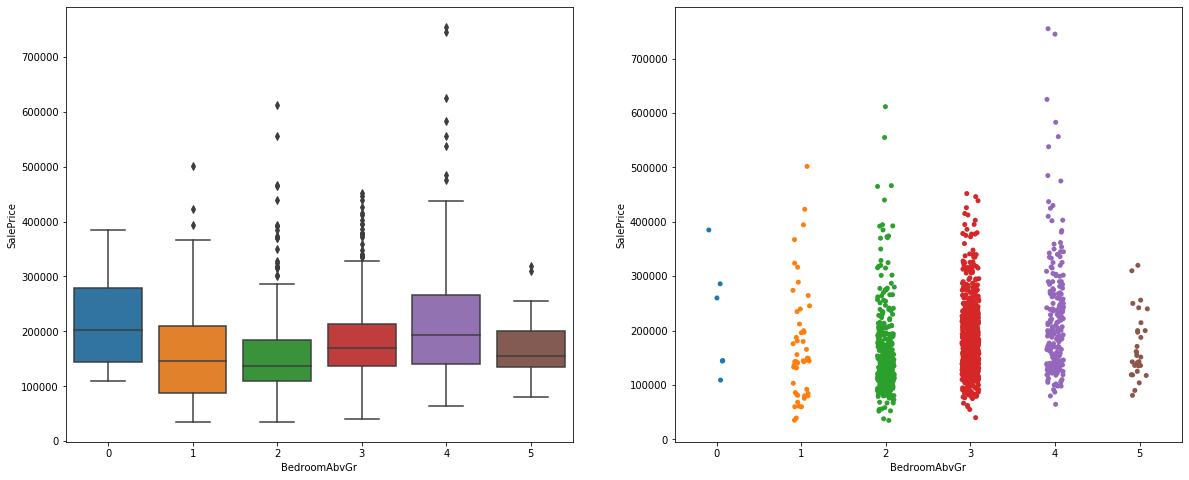

In [48]:
make_discrete_plot("BedroomAbvGr",0,0)

In [0]:
# change type to category
dataset.BedroomAbvGr = dataset.BedroomAbvGr.astype(str)

KitchenAbvGr


---



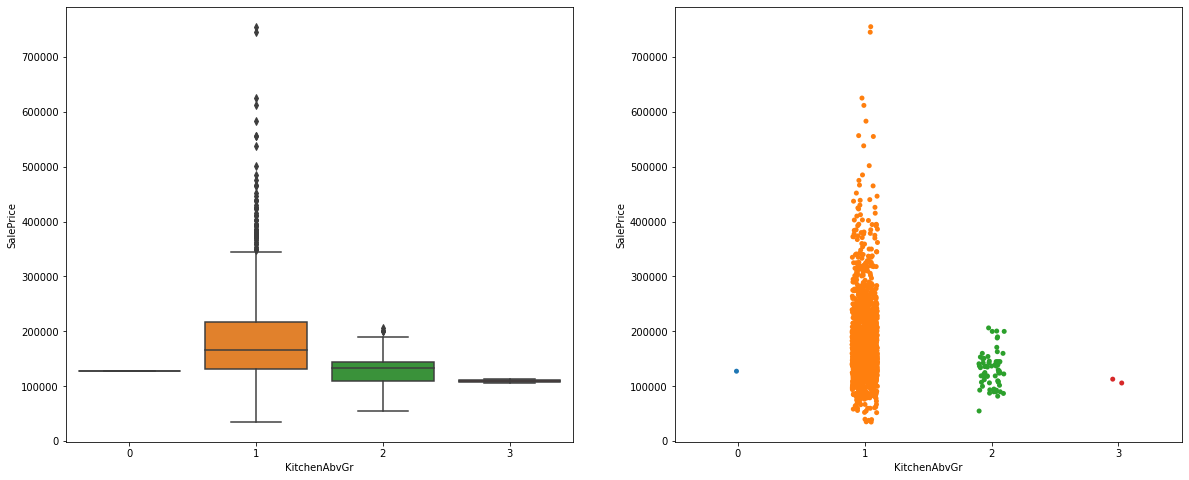

In [50]:
make_discrete_plot("KitchenAbvGr",0,0)

In [0]:
# there few values equal to 0 or 3, so let's put them together with other classes
dataset.KitchenAbvGr = dataset.KitchenAbvGr.apply(lambda x: 1 if x == 0 else(2 if x == 3 else x))

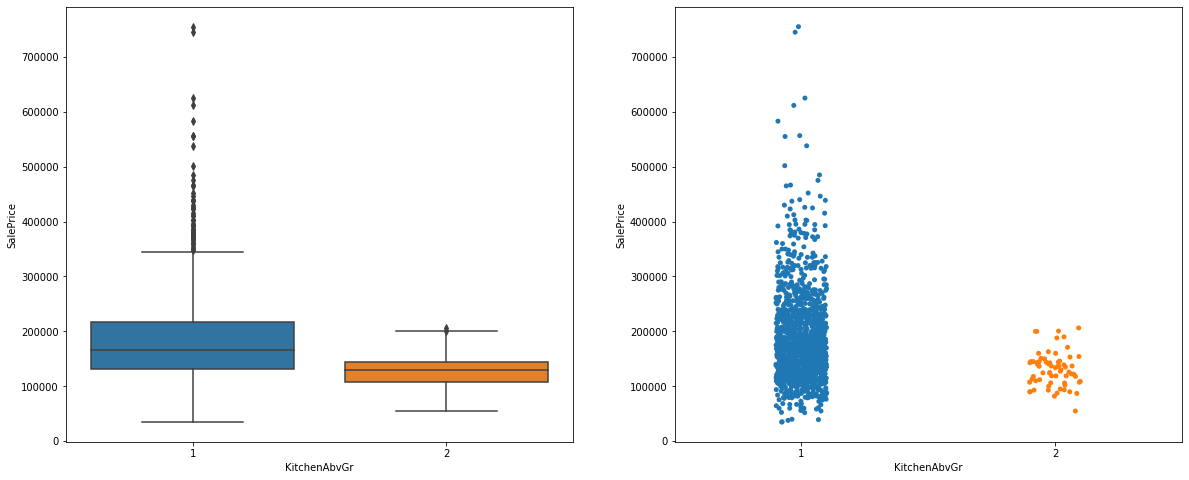

In [52]:
make_discrete_plot("KitchenAbvGr",0,0)

In [0]:
# change type to category
dataset.KitchenAbvGr = dataset.KitchenAbvGr.astype(str)

TotRmsAbvGrd

> Total rooms above grade (does not include bathrooms).



---




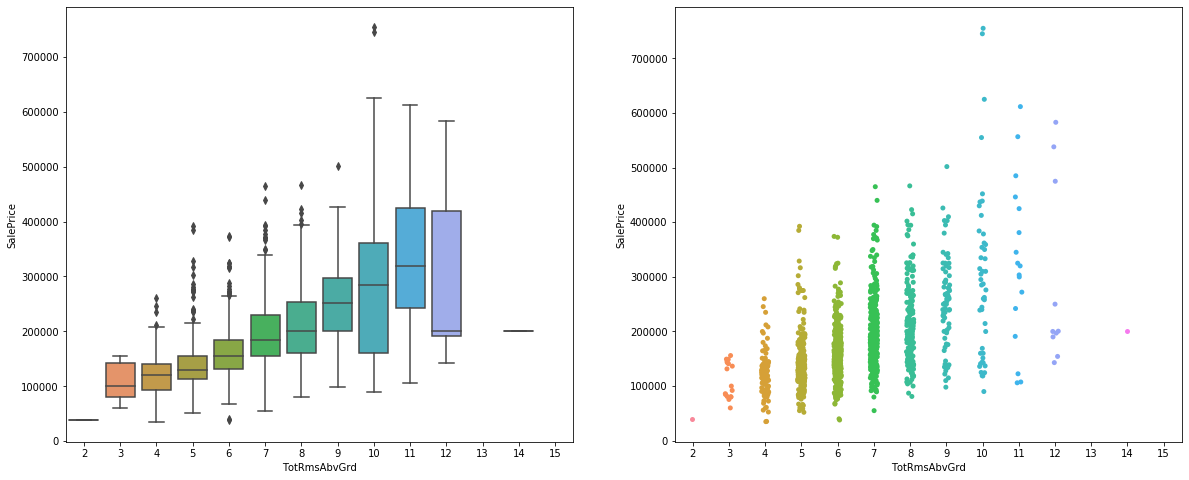

In [54]:


make_discrete_plot("TotRmsAbvGrd",0,0)

In [0]:
dataset.TotRmsAbvGrd = dataset.TotRmsAbvGrd.apply(lambda x: 3 if x == 2 else(11 if x>11 else x))

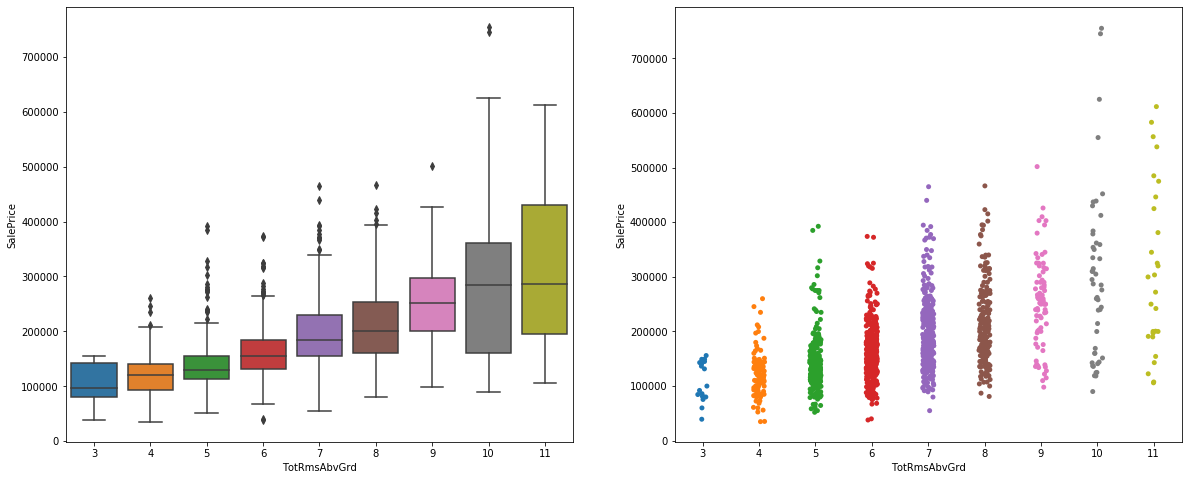

In [56]:
make_discrete_plot("TotRmsAbvGrd",0,0)

Fireplaces


> Number of fireplaces.


---





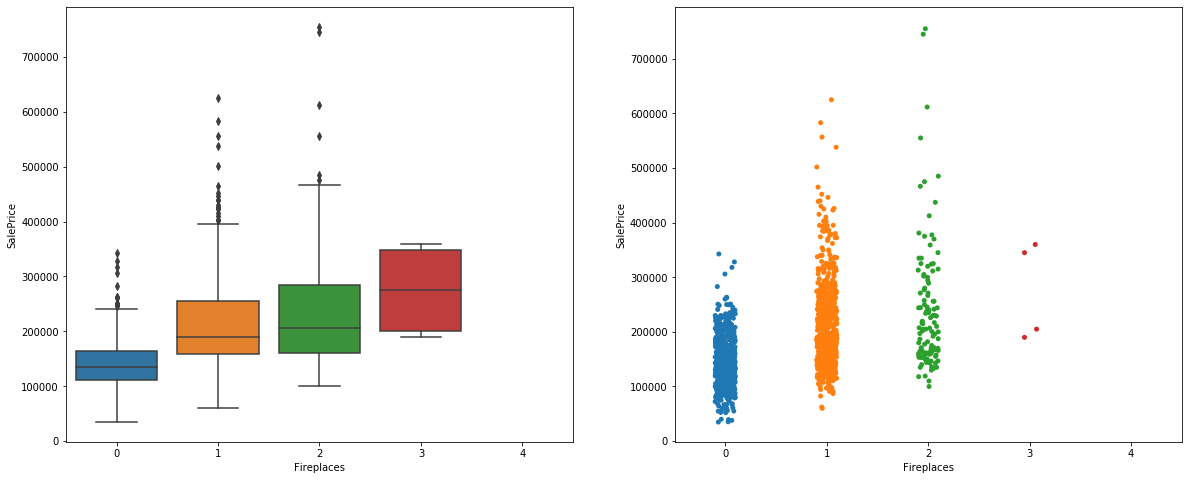

In [58]:
make_discrete_plot("Fireplaces",0,0)

In [0]:
# there few values greater than 2, so let's flag
dataset.Fireplaces = dataset.Fireplaces.apply(lambda x: 1 if x > 1 else x)

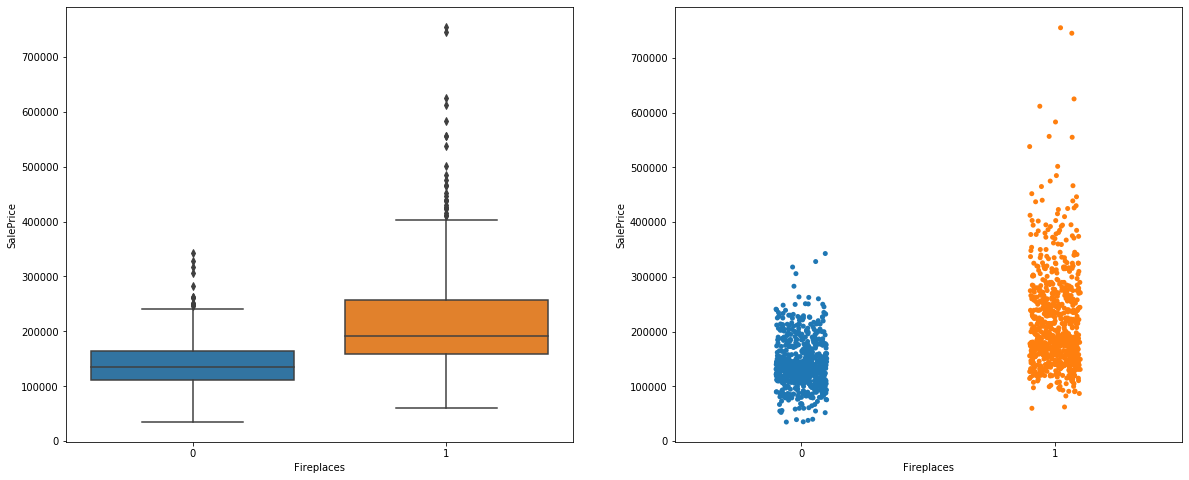

In [60]:
make_discrete_plot("Fireplaces",0,0)

GarageCars

> Size of garage in car capacity.


---





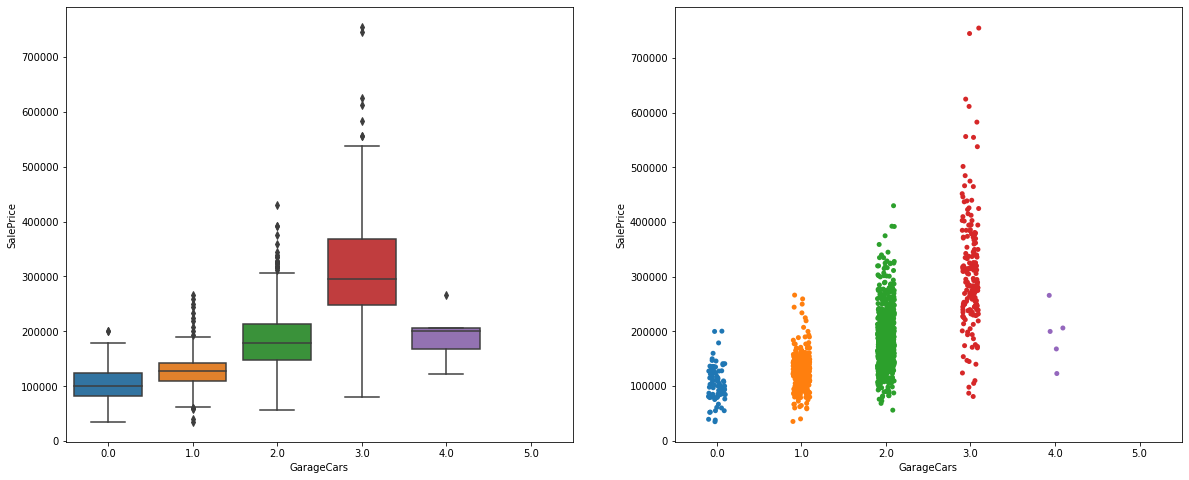

In [61]:
make_discrete_plot("GarageCars",0,0)

In [0]:
# there few values greater than 3, so let's put them together with other classes
dataset.GarageCars = dataset.GarageCars.apply(lambda x: 3 if x > 3 else x)

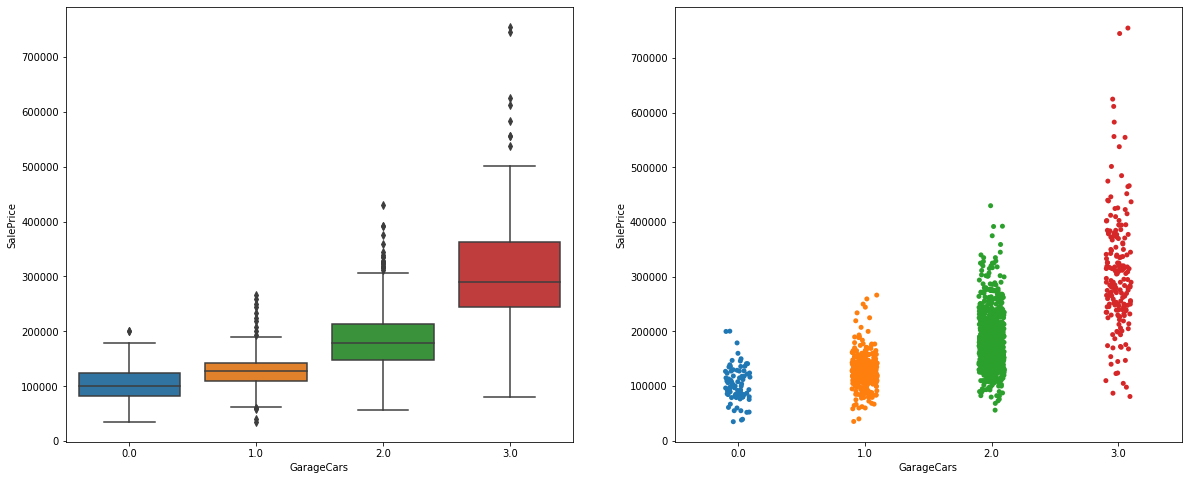

In [64]:
make_discrete_plot("GarageCars",0,0)

GarageYrBlt

> Year garage was built.

---





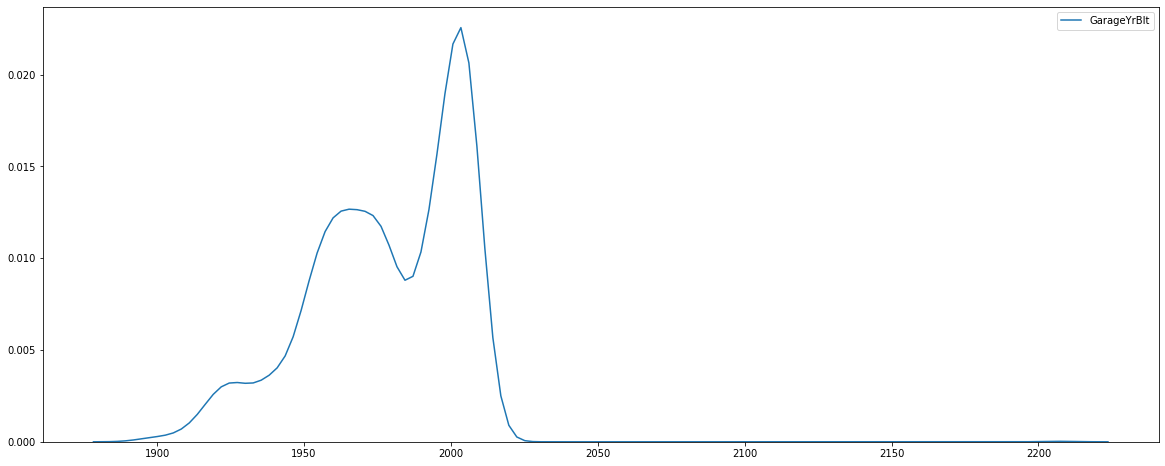

In [65]:
plt.figure(figsize=(20,8))
sns.kdeplot(dataset["GarageYrBlt"][dataset["GarageYrBlt"] != 'NA'])
plt.show()

In [66]:
dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'].sort_values(ascending= False).head(3) 
# this is strange, probably 2207 is 2007

2590    2207
1606    2010
1500    2010
Name: GarageYrBlt, dtype: object

In [67]:
dataset.GarageYrBlt[dataset.GarageYrBlt==2207] = 2007

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
# Let's transform those values into categories
min(dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'].values)

1895.0

In [69]:
bins = [1890, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2011]
names = ['-1920', '1920-1940', '1940-1950', '1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'] = pd.cut(dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'], 
                                                             bins, 
                                                             labels=names)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
# change type from category to str
dataset.GarageYrBlt = dataset.GarageYrBlt.astype(str)

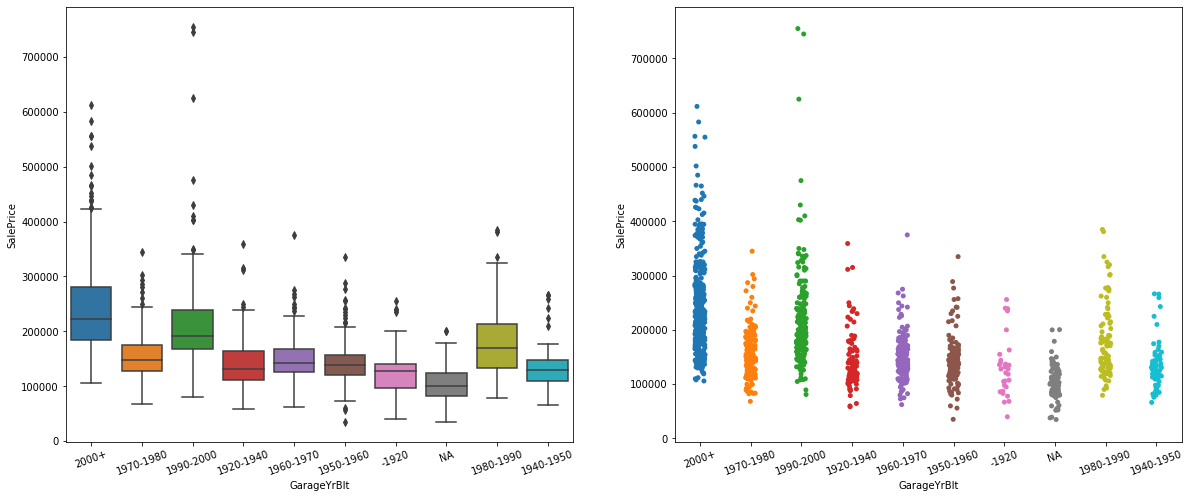

In [71]:
make_discrete_plot("GarageYrBlt",20,20)

YearRemodAdd

> Remodel date (same as construction date if no remodeling or additions).

---





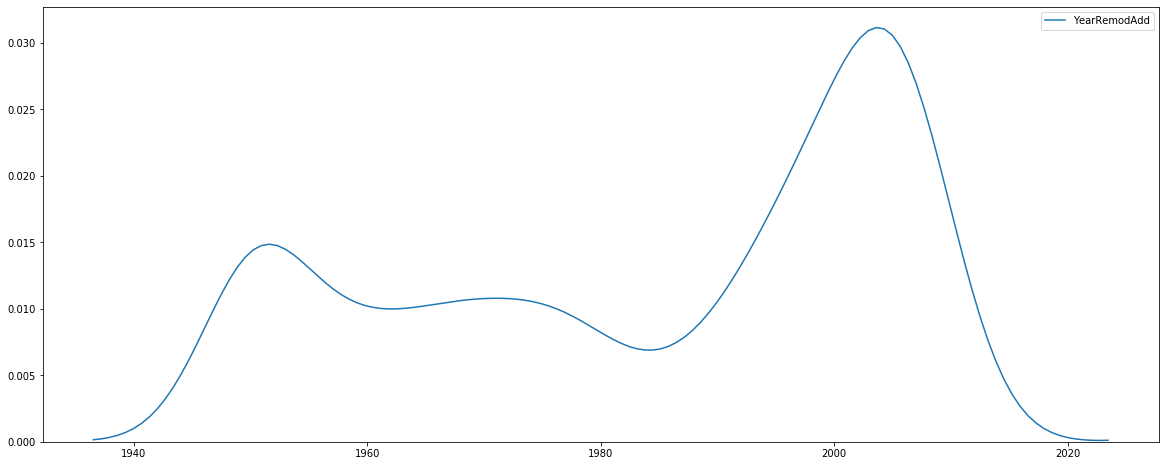

In [72]:
plt.figure(figsize=(20,8))
sns.kdeplot(dataset["YearRemodAdd"])
plt.show()

In [73]:
print(min(dataset.YearRemodAdd[dataset["YearRemodAdd"] != 'NA'].values), ',', max(dataset.YearRemodAdd[dataset["YearRemodAdd"] != 'NA'].values))

1950 , 2010


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
bins = [1949, 1960, 1970, 1980, 1990, 2000, 2011]
names = ['1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

dataset.YearRemodAdd = pd.cut(dataset.YearRemodAdd, bins, labels=names)

In [0]:
# change type from category to str
dataset.YearRemodAdd = dataset.YearRemodAdd.astype(str)

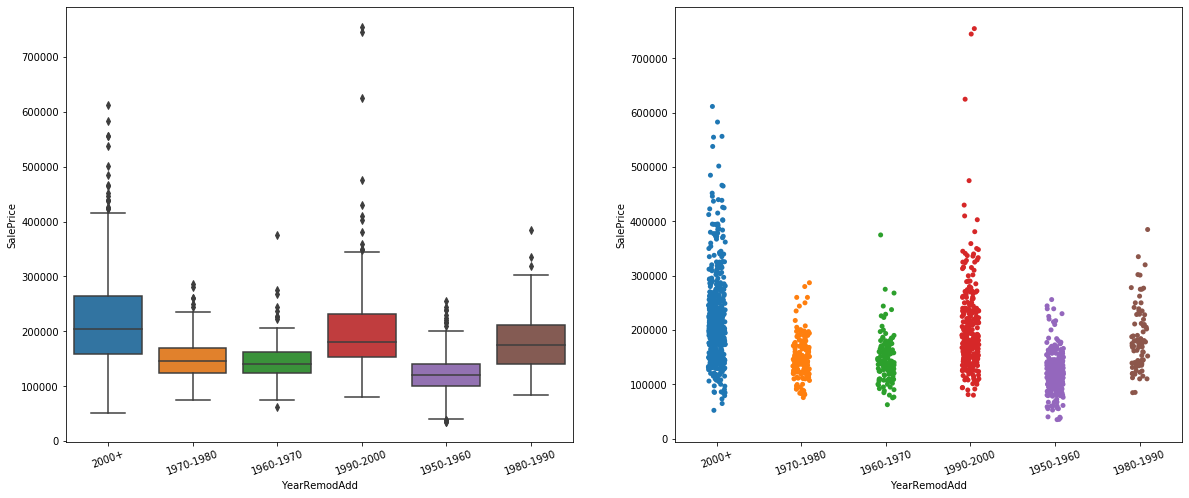

In [76]:
make_discrete_plot("YearRemodAdd",20,20)

YearBuilt


> Original construction date.

---





/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


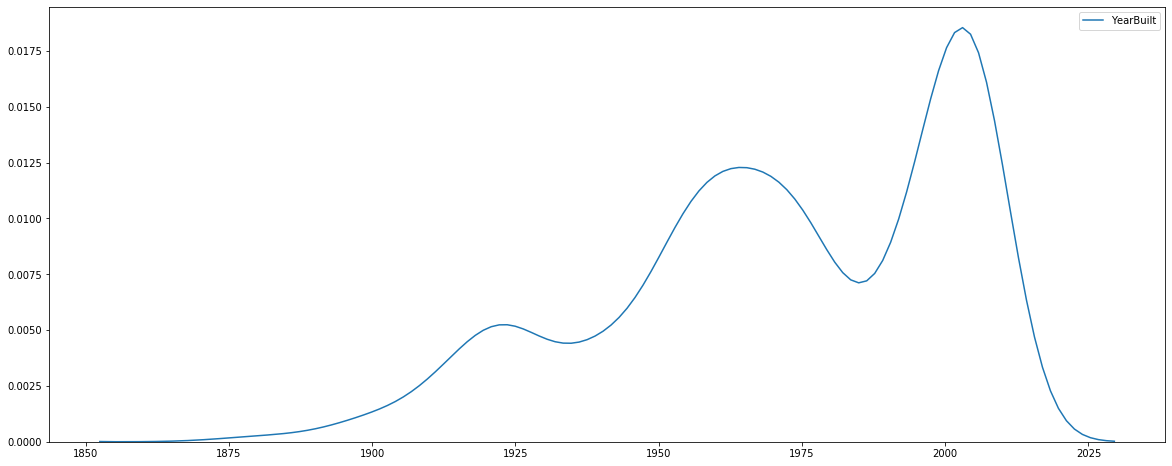

In [77]:
plt.figure(figsize=(20,8))
sns.kdeplot(dataset["YearBuilt"][dataset["YearBuilt"] != 'NA'])
plt.show()

In [79]:
# Let's transform those values into categories
print(min(dataset.YearBuilt[dataset["YearBuilt"] != 'NA'].values), ',',
      max(dataset.YearBuilt[dataset["YearBuilt"] != 'NA'].values))

1872 , 2010


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
bins = [1870, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2011]
names = ['-1920', '1920-1940', '1940-1950', '1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

dataset.YearBuilt = pd.cut(dataset.YearBuilt, bins, labels=names)

In [0]:
# change type from category to str
dataset.YearBuilt = dataset.YearBuilt.astype(str)

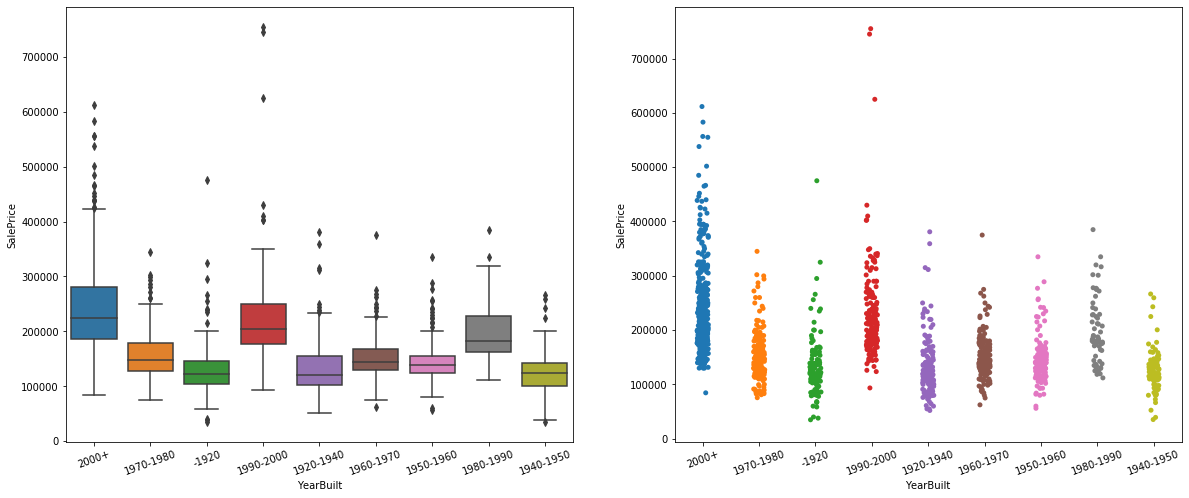

In [82]:
make_discrete_plot("YearBuilt",20,20)

YrSold

> Year Sold (YYYY).
---





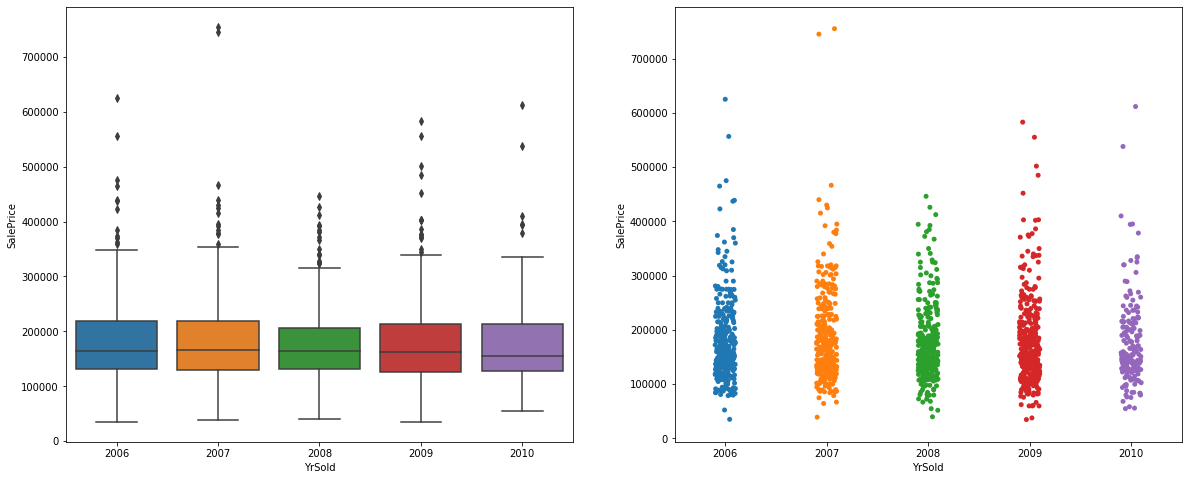

In [83]:
make_discrete_plot("YrSold",0,0)

In [0]:
# change type from int to str
dataset.YrSold = dataset.YrSold.astype(str)

MoSold

> Month Sold (MM).

---





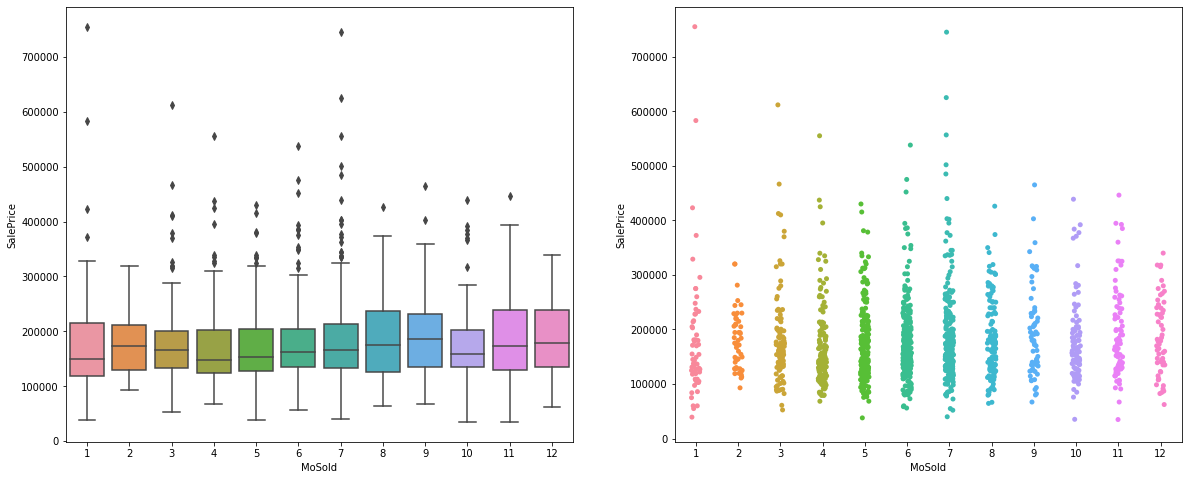

In [86]:
make_discrete_plot("MoSold",0,0)

In [0]:
# change type from int to str
dataset.MoSold = dataset.MoSold.astype(str)